Baseline model

This sheet contains:

2. DOM baseline model
3. Time interval baseline model

## 1. EDA

## Add comments on EDA and the approach

In [ ]:
#required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import chardet
import datetime

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn import linear_model

from sklearn.svm import SVR
from sklearn.svm import LinearSVC

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from sklearn.preprocessing import StandardScaler

import seaborn as sns
color = sns.color_palette()

%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [ ]:
# Attempting to model DOM (Days on markets) of each property
df = pd.read_csv('../data/denver_mean_dom_discretize.csv')

df["list_date"] = pd.to_datetime(df["list_date"])
df["sale_date"] = pd.to_datetime(df["sale_date"])

mapping = {k: v for v, k in enumerate(df.property_type.unique())}
mapping

NameError: name 'pd' is not defined

In [ ]:
scaler = StandardScaler()

In [ ]:
# df['dom'] = (df['sale_date'] - df['list_date']).dt.days.astype('int16')
df = df[(df['sqft'] < 6000) & (df['sale_price_per_sqft'] < 500)].copy()
df['property_type_code'] = df['property_type'].map(mapping)

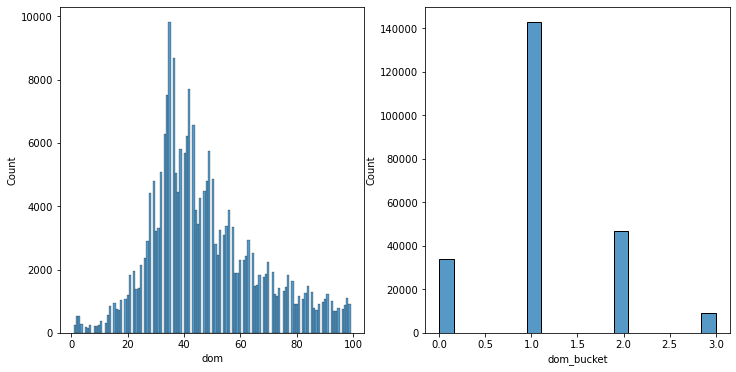

In [ ]:
# df['dom'].hist(bins=30)
f, ax = plt.subplots(1,2)
f.set_size_inches(12, 6, forward=True)
sns.histplot(df['dom'],ax=ax[0])
sns.histplot(df['dom_bucket'], ax=ax[1])

In [ ]:
df.describe()

,property_id,zipcode,fips,sqft,sale_price_per_sqft,farm_score,median_rental_price,pop_density,first_time_homebuyer_score,retirement_friendly_score,young_single_professional_score,college_student_friendly_score,violent_crime_rate,walk,public_transportation,carpool,dom,mean_dom,dom_bucket,property_type_code
count,2.324980e+05,232498.00000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000
mean,2.345544e+08,80204.90221,8142.678771,1927.604547,235.278704,86.785048,2155.167381,4454.681361,64.241069,62.062904,41.975798,59.048684,4.318042,0.017281,0.035283,0.079935,47.434851,47.403507,1.133713,0.314368
std,1.787886e+08,178.40921,2030.741351,907.524772,77.197999,29.297348,581.299342,3202.533467,38.305556,23.835901,13.238119,22.919682,3.744564,0.031375,0.031316,0.039587,19.413427,2.293873,0.697080,0.552592
min,1.021800e+04,80002.00000,5069.000000,120.000000,0.624376,0.000000,935.000000,1.190135,0.383779,0.710770,3.042529,3.956666,0.000000,0.000000,0.000000,0.000000,1.000000,40.695264,0.000000,0.000000
25%,1.386529e+08,80030.00000,8005.000000,1260.000000,181.023720,100.000000,1724.000000,2136.487544,24.969933,45.952597,34.510855,41.245291,1.620370,0.003164,0.012418,0.053691,34.000000,45.826744,1.000000,0.000000
50%,1.401357e+08,80204.00000,8031.000000,1750.000000,219.026549,100.000000,2077.000000,4137.942853,100.000000,66.516814,45.040448,61.079491,3.022453,0.008577,0.027169,0.072952,43.000000,47.352444,1.000000,0.000000
75%,3.219761e+08,80241.00000,8059.000000,2384.000000,272.203667,100.000000,2485.000000,6082.974111,100.000000,81.925541,50.886820,77.841018,5.956320,0.019688,0.048770,0.098507,58.000000,49.056486,1.000000,1.000000
max,2.146689e+09,80643.00000,51153.000000,5995.000000,499.886364,100.000000,5009.000000,31336.205118,100.000000,99.975254,78.137148,99.363469,39.370079,0.457666,0.204571,0.316316,99.000000,52.942220,3.000000,5.000000


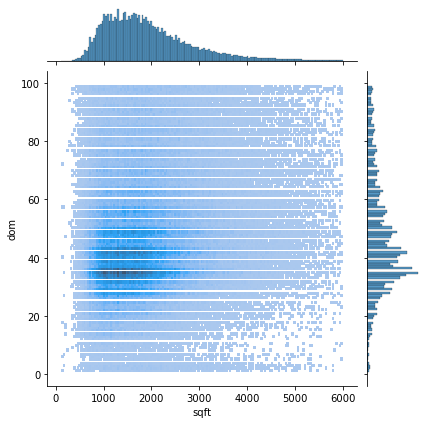

In [ ]:
sns.jointplot(x = df.sqft, y = df.dom, height=6, kind='hist')

In [ ]:
feature_columns = ['sqft', 'sale_price_per_sqft', 'median_rental_price', 'pop_density', 
                  'violent_crime_rate', 'public_transportation', 'carpool', 'fips', 'zipcode']

nrows = 3
ncols = 3

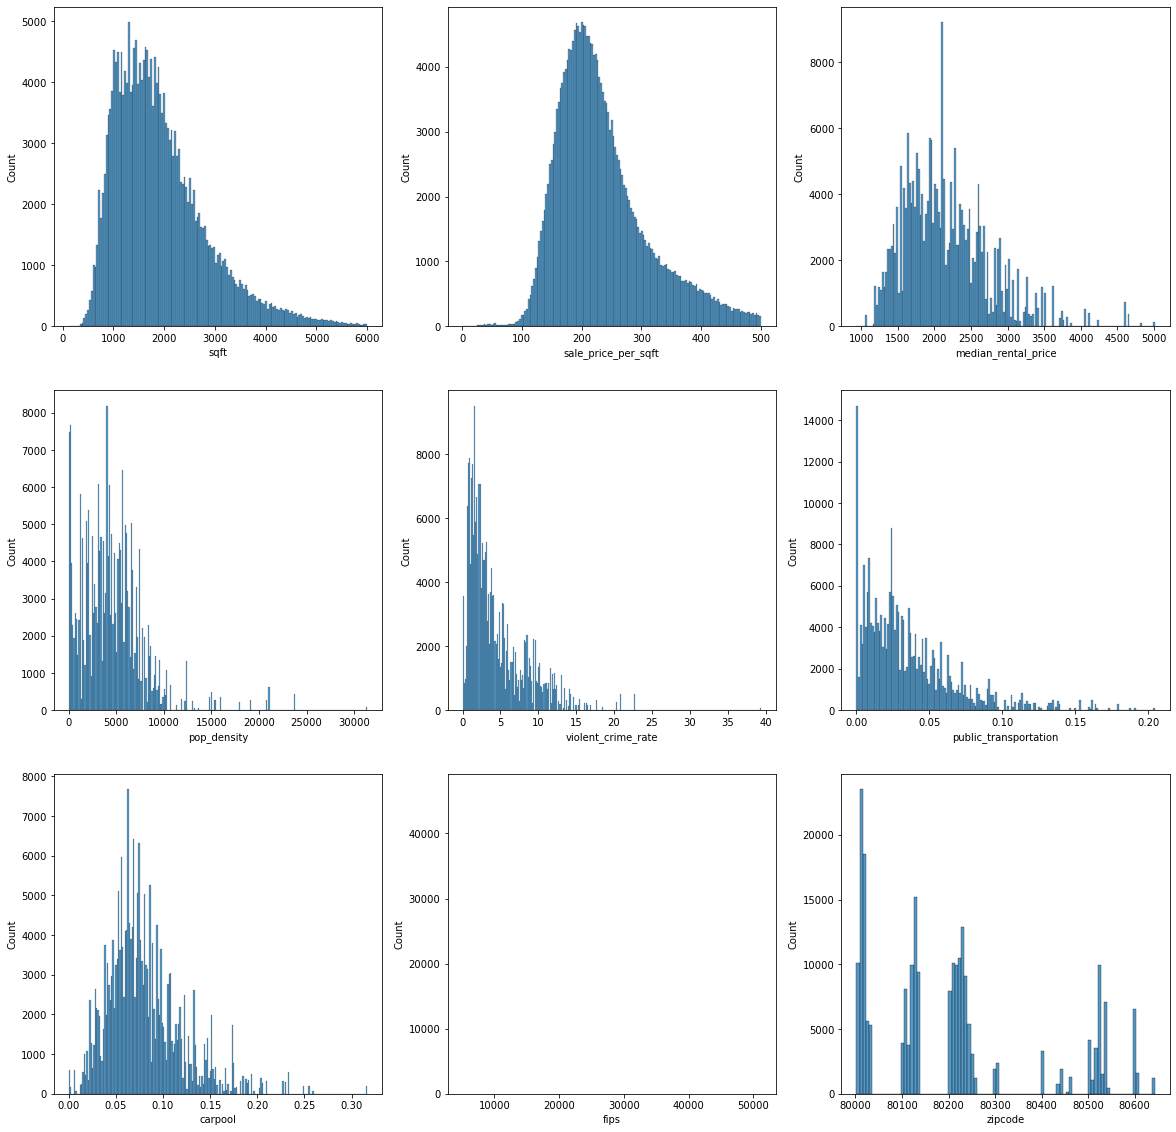

In [ ]:
# Plotting the distribution of each column
fig, ax = plt.subplots(nrows, ncols)
fig.set_size_inches(20, 20, forward=True)

for i, col in enumerate(feature_columns):
  row_idx = i // ncols
  col_idx = i % ncols
  
  sns.histplot(df[col], ax=ax[row_idx, col_idx])
plt.show()

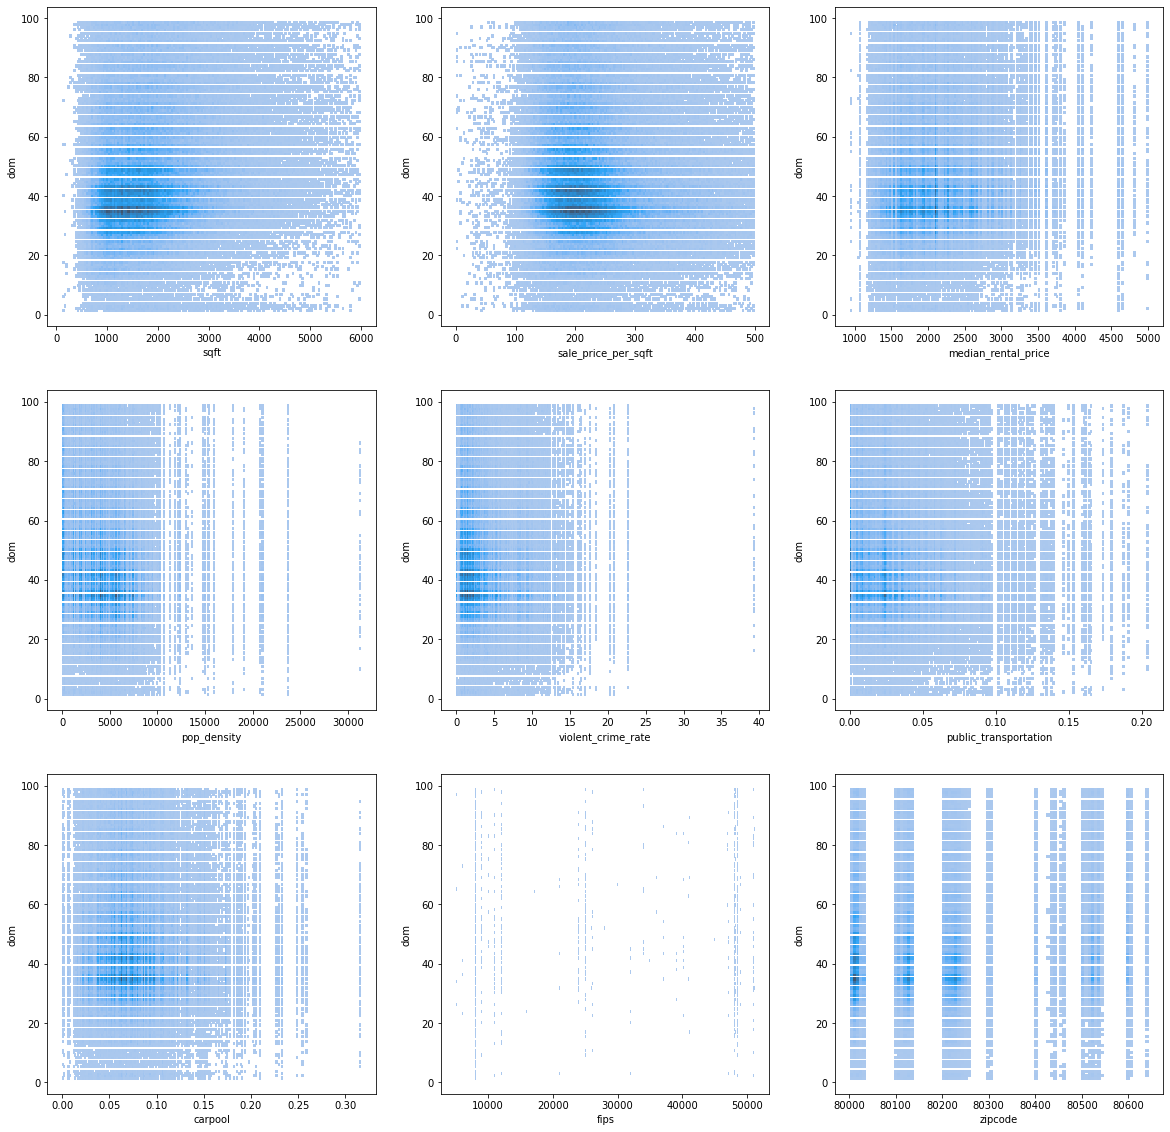

In [ ]:
# Plotting each column against y (days-on-market)
fig, ax = plt.subplots(nrows, ncols)
fig.set_size_inches(20, 20, forward=True)

for i, col in enumerate(feature_columns):
  row_idx = i // ncols
  col_idx = i % ncols
  
  sns.histplot(df, ax=ax[row_idx, col_idx], x=col, y='dom')
plt.show()

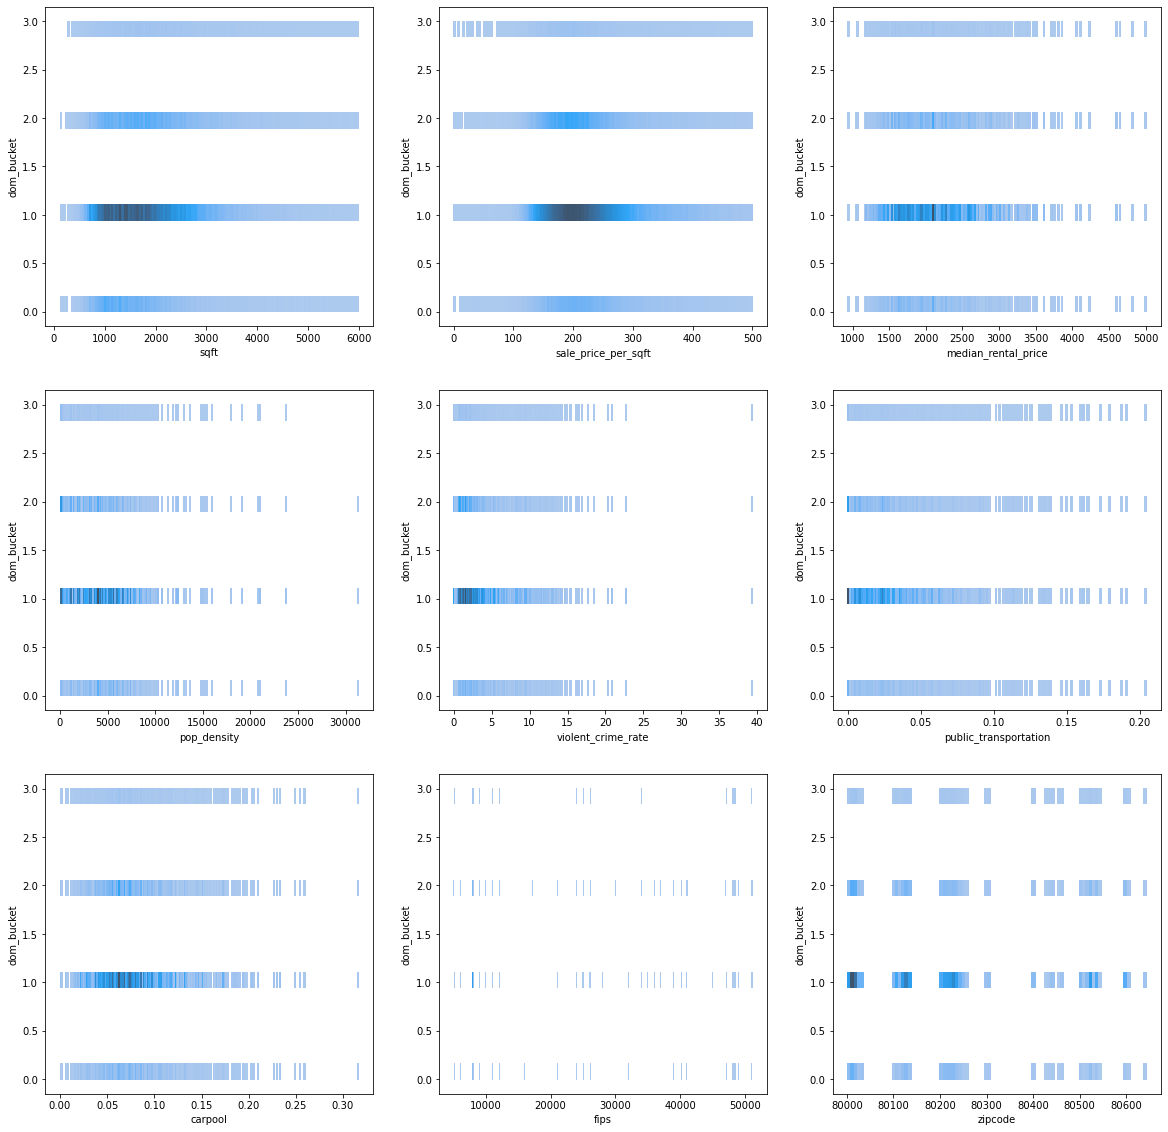

In [ ]:
# Plotting each column against y (days-on-market bucket, the discretized version of dom)

fig, ax = plt.subplots(nrows, ncols)
fig.set_size_inches(20, 20, forward=True)

for i, col in enumerate(feature_columns):
  row_idx = i // ncols
  col_idx = i % ncols
  
  sns.histplot(df, ax=ax[row_idx, col_idx], x=col, y='dom_bucket')
plt.show()

In [ ]:
df.describe()

,property_id,zipcode,fips,sqft,sale_price_per_sqft,farm_score,median_rental_price,pop_density,first_time_homebuyer_score,retirement_friendly_score,young_single_professional_score,college_student_friendly_score,violent_crime_rate,walk,public_transportation,carpool,dom,mean_dom,dom_bucket,property_type_code
count,2.324980e+05,232498.00000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000
mean,2.345544e+08,80204.90221,8142.678771,1927.604547,235.278704,86.785048,2155.167381,4454.681361,64.241069,62.062904,41.975798,59.048684,4.318042,0.017281,0.035283,0.079935,47.434851,47.403507,1.133713,0.314368
std,1.787886e+08,178.40921,2030.741351,907.524772,77.197999,29.297348,581.299342,3202.533467,38.305556,23.835901,13.238119,22.919682,3.744564,0.031375,0.031316,0.039587,19.413427,2.293873,0.697080,0.552592
min,1.021800e+04,80002.00000,5069.000000,120.000000,0.624376,0.000000,935.000000,1.190135,0.383779,0.710770,3.042529,3.956666,0.000000,0.000000,0.000000,0.000000,1.000000,40.695264,0.000000,0.000000
25%,1.386529e+08,80030.00000,8005.000000,1260.000000,181.023720,100.000000,1724.000000,2136.487544,24.969933,45.952597,34.510855,41.245291,1.620370,0.003164,0.012418,0.053691,34.000000,45.826744,1.000000,0.000000
50%,1.401357e+08,80204.00000,8031.000000,1750.000000,219.026549,100.000000,2077.000000,4137.942853,100.000000,66.516814,45.040448,61.079491,3.022453,0.008577,0.027169,0.072952,43.000000,47.352444,1.000000,0.000000
75%,3.219761e+08,80241.00000,8059.000000,2384.000000,272.203667,100.000000,2485.000000,6082.974111,100.000000,81.925541,50.886820,77.841018,5.956320,0.019688,0.048770,0.098507,58.000000,49.056486,1.000000,1.000000
max,2.146689e+09,80643.00000,51153.000000,5995.000000,499.886364,100.000000,5009.000000,31336.205118,100.000000,99.975254,78.137148,99.363469,39.370079,0.457666,0.204571,0.316316,99.000000,52.942220,3.000000,5.000000


In [ ]:
'''
def calculate_mean_dom(x):
  before = x['list_date'] - pd.Timedelta(days=90)
  
  near_dates = df[(df['list_date'] >= before) & (df['list_date'] < x['list_date'])]
  mean_dom = near_dates['dom'].mean()
  if mean_dom > 0:
    x.at['mean_dom'] = mean_dom
  return x
'''

"\ndef calculate_mean_dom(x):\n  before = x['list_date'] - pd.Timedelta(days=90)\n  \n  near_dates = df[(df['list_date'] >= before) & (df['list_date'] < x['list_date'])]\n  mean_dom = near_dates['dom'].mean()\n  if mean_dom > 0:\n    x.at['mean_dom'] = mean_dom\n  return x\n"

In [ ]:
# df['mean_dom'] = df['dom'].mean()

In [ ]:
# df = df.apply(calculate_mean_dom, axis=1)

In [ ]:
# df['mean_dom'].hist(bins=20)

In [ ]:
'''
def discretize_dom(x):
  if x['dom'] < 90:
    x.at['dom_bucket'] = x['dom'] // 30
  else:
    x.at['dom_bucket'] = 3
  return x
'''

"\ndef discretize_dom(x):\n  if x['dom'] < 90:\n    x.at['dom_bucket'] = x['dom'] // 30\n  else:\n    x.at['dom_bucket'] = 3\n  return x\n"

In [ ]:
# df['dom_bucket'] = 0
# df = df.apply(discretize_dom, axis=1)

In [ ]:
# df.to_csv('../data/denver_mean_dom_discretize.csv', index=False)

In [ ]:
# df['dom_bucket'].hist(bins=4)

## DOM Baseline Model
The baseline approach aims to:

1. Make predictions on number of days on the market for a listed house using a continuous approach
2. Make predictions on the number of days on the market where the days are segmented into 4 categories, whether the properties are sold within 1,2,3 or 4 or greater months

### Classification models

In [ ]:
small_df = df[df.zipcode == 80134]

y2 = small_df['dom_bucket'].copy()

X2 = small_df.drop(columns=['property_id', 'list_date', 'sale_date', 'dom', 
                     'farm_score', 'fips', 
                     'first_time_homebuyer_score', 'dom_bucket', 'property_type'])

columns_to_scale = ['zipcode', 'sqft', 'sale_price_per_sqft', 'median_rental_price', 
                    'pop_density', 'retirement_friendly_score',
                    'college_student_friendly_score', 'violent_crime_rate', 'young_single_professional_score',
                    'property_type_code'
                   ]
X2[columns_to_scale] =  scaler.fit_transform(X2[columns_to_scale])

X2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6984 entries, 50436 to 129465
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   zipcode                          6984 non-null   float64
 1   sqft                             6984 non-null   float64
 2   has_central_air                  6984 non-null   bool   
 3   has_jacuzzi                      6984 non-null   bool   
 4   has_pool                         6984 non-null   bool   
 5   has_solar                        6984 non-null   bool   
 6   has_garage                       6984 non-null   bool   
 7   sale_price_per_sqft              6984 non-null   float64
 8   median_rental_price              6984 non-null   float64
 9   pop_density                      6984 non-null   float64
 10  retirement_friendly_score        6984 non-null   float64
 11  young_single_professional_score  6984 non-null   float64
 12  college_studen

In [ ]:
X2.describe()

,zipcode,sqft,sale_price_per_sqft,median_rental_price,pop_density,retirement_friendly_score,young_single_professional_score,college_student_friendly_score,violent_crime_rate,walk,public_transportation,carpool,mean_dom,property_type_code
count,6984.0,6.984000e+03,6.984000e+03,6.984000e+03,6.984000e+03,6.984000e+03,6.984000e+03,6.984000e+03,6.984000e+03,6984.000000,6984.000000,6984.000000,6984.000000,6.984000e+03
mean,0.0,1.511574e-16,5.263703e-16,9.267692e-15,2.989826e-14,7.170031e-16,1.309987e-14,-1.090263e-14,4.322367e-15,0.007251,0.019127,0.068409,47.325047,7.301878e-15
std,0.0,1.000072e+00,1.000072e+00,1.000072e+00,1.000072e+00,1.000072e+00,1.000072e+00,1.000072e+00,1.000072e+00,0.006682,0.014390,0.029136,2.268245,1.000072e+00
min,0.0,-1.690600e+00,-4.024447e+00,-2.159276e+00,-1.642564e+00,-2.040978e+00,-3.961079e+00,-1.522161e+00,-1.725850e+00,0.000000,0.000000,0.024776,41.232412,-4.536323e-01
25%,0.0,-7.478036e-01,-7.001723e-01,-9.490542e-01,-7.000356e-01,-5.013786e-01,-1.399725e+00,-1.203379e+00,-4.845671e-01,0.000000,0.008537,0.048476,45.819303,-4.536323e-01
50%,0.0,-1.715930e-01,-3.123080e-02,-3.089372e-01,3.312325e-01,3.288406e-01,3.306036e-01,7.117653e-01,-1.487855e-01,0.007507,0.013360,0.063245,47.250742,-4.536323e-01
75%,0.0,6.010765e-01,6.010313e-01,1.231345e+00,7.256751e-01,7.123037e-01,9.190170e-01,7.364917e-01,1.095490e+00,0.008741,0.023831,0.085977,48.979712,-4.536323e-01
max,0.0,3.774107e+00,6.192578e+00,2.764125e+00,2.551021e+00,1.586911e+00,1.607231e+00,1.829849e+00,1.401154e+01,0.050211,0.045041,0.135781,52.942220,4.168057e+00


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.33, random_state =297)

In [ ]:
def print_results(model):
  print('Train set accuracy: {}'.format(model.score(X_train, y_train)))
  print('Test set accuracy: {}'.format(model.score(X_test, y_test)))

#### Logistic Regression

In [ ]:
logit_reg = LogisticRegression()
logit_reg.fit(X_train, y_train)

print_results(logit_reg)

Train set accuracy: 0.6279119469972216
Test set accuracy: 0.6238611713665944


/Users/namluu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
#these are the values in the train set
y_train.value_counts()

1    2948
2    1023
0     507
3     201
Name: dom_bucket, dtype: int64

In [ ]:
y_test.value_counts()

1    1439
2     500
0     259
3     107
Name: dom_bucket, dtype: int64

In [ ]:
#these are the values predicted by the baseline model
np.unique(logit_reg.predict(X_train))

array([1, 2])

In [ ]:
#average one v rest AUC score
roc_auc_score(y_test, logit_reg.predict_proba(X_test), multi_class='ovr', average='weighted')

0.5656501283105883

#### Extra Trees Classifier

In [ ]:
etc = ExtraTreesClassifier(n_estimators=20)
etc.fit(X_train, y_train)

print_results(etc)

Train set accuracy: 1.0
Test set accuracy: 0.5540130151843817


In [ ]:
#average one v rest score
roc_auc_score(y_test, etc.predict_proba(X_test), multi_class='ovr', average='weighted')

0.552341532359665

In [ ]:
feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                        etc.estimators_], 
                                        axis = 0) 

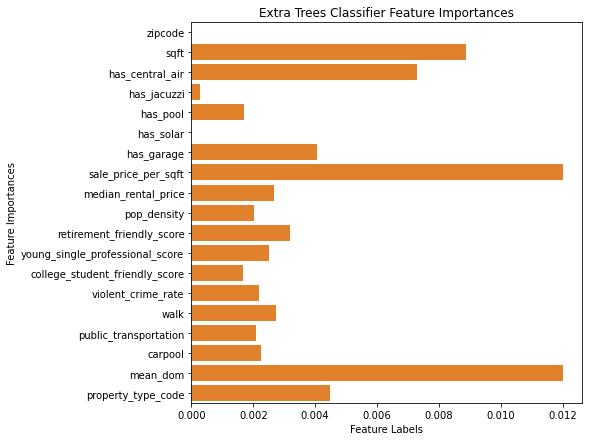

In [ ]:
plt.figure(figsize=(7,7))
sns.barplot(y=X2.columns, x=feature_importance_normalized, orient='h', color=color[1]) 
plt.xlabel('Feature Labels') 
plt.ylabel('Feature Importances') 
plt.title('Extra Trees Classifier Feature Importances') 
plt.show() 

#### Random Forest Classifier

In [ ]:
rfc = RandomForestClassifier(max_depth=5, random_state=0)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=0)

In [ ]:
#average one v rest score
roc_auc_score(y_test, rfc.predict_proba(X_test), multi_class='ovr', average='weighted')

0.5949890264843193

In [ ]:
print_results(rfc)

Train set accuracy: 0.6356058986963026
Test set accuracy: 0.6264642082429501


In [ ]:
feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                        rfc.estimators_], 
                                        axis = 0) 

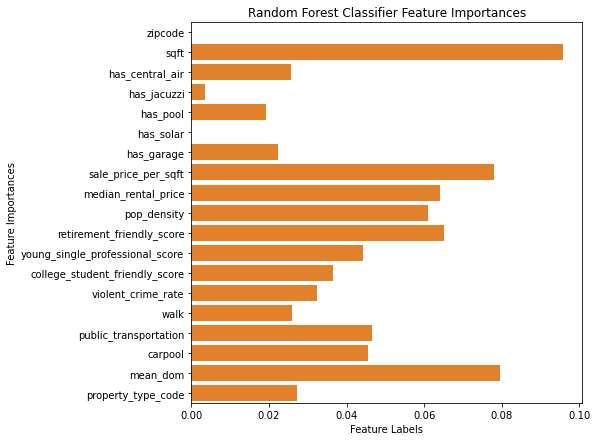

In [ ]:
plt.figure(figsize=(7,7))
sns.barplot(y=X2.columns, x=feature_importance_normalized, orient='h', color=color[1]) 
plt.xlabel('Feature Labels') 
plt.ylabel('Feature Importances') 
plt.title('Random Forest Classifier Feature Importances') 
plt.show() 

### Regression Model

In [ ]:
small_df = df[df.zipcode == 80134]
y = small_df['dom'].copy()

X = small_df.drop(columns=['property_id', 'list_date', 'sale_date', 'dom', 
                     'farm_score', 'fips', 
                     'first_time_homebuyer_score', 'dom_bucket', 'property_type'])

columns_to_scale = ['zipcode', 'sqft', 'sale_price_per_sqft', 'median_rental_price', 
                    'pop_density', 'retirement_friendly_score',
                    'college_student_friendly_score', 'violent_crime_rate', 'young_single_professional_score',
                    'property_type_code'
                   ]
X[columns_to_scale] =  scaler.fit_transform(X[columns_to_scale])

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6984 entries, 50436 to 129465
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   zipcode                          6984 non-null   float64
 1   sqft                             6984 non-null   float64
 2   has_central_air                  6984 non-null   bool   
 3   has_jacuzzi                      6984 non-null   bool   
 4   has_pool                         6984 non-null   bool   
 5   has_solar                        6984 non-null   bool   
 6   has_garage                       6984 non-null   bool   
 7   sale_price_per_sqft              6984 non-null   float64
 8   median_rental_price              6984 non-null   float64
 9   pop_density                      6984 non-null   float64
 10  retirement_friendly_score        6984 non-null   float64
 11  young_single_professional_score  6984 non-null   float64
 12  college_studen

In [ ]:
X.describe()

,zipcode,sqft,sale_price_per_sqft,median_rental_price,pop_density,retirement_friendly_score,young_single_professional_score,college_student_friendly_score,violent_crime_rate,walk,public_transportation,carpool,mean_dom,property_type_code
count,6984.0,6.984000e+03,6.984000e+03,6.984000e+03,6.984000e+03,6.984000e+03,6.984000e+03,6.984000e+03,6.984000e+03,6984.000000,6984.000000,6984.000000,6984.000000,6.984000e+03
mean,0.0,1.511574e-16,5.263703e-16,9.267692e-15,2.989826e-14,7.170031e-16,1.309987e-14,-1.090263e-14,4.322367e-15,0.007251,0.019127,0.068409,47.325047,7.301878e-15
std,0.0,1.000072e+00,1.000072e+00,1.000072e+00,1.000072e+00,1.000072e+00,1.000072e+00,1.000072e+00,1.000072e+00,0.006682,0.014390,0.029136,2.268245,1.000072e+00
min,0.0,-1.690600e+00,-4.024447e+00,-2.159276e+00,-1.642564e+00,-2.040978e+00,-3.961079e+00,-1.522161e+00,-1.725850e+00,0.000000,0.000000,0.024776,41.232412,-4.536323e-01
25%,0.0,-7.478036e-01,-7.001723e-01,-9.490542e-01,-7.000356e-01,-5.013786e-01,-1.399725e+00,-1.203379e+00,-4.845671e-01,0.000000,0.008537,0.048476,45.819303,-4.536323e-01
50%,0.0,-1.715930e-01,-3.123080e-02,-3.089372e-01,3.312325e-01,3.288406e-01,3.306036e-01,7.117653e-01,-1.487855e-01,0.007507,0.013360,0.063245,47.250742,-4.536323e-01
75%,0.0,6.010765e-01,6.010313e-01,1.231345e+00,7.256751e-01,7.123037e-01,9.190170e-01,7.364917e-01,1.095490e+00,0.008741,0.023831,0.085977,48.979712,-4.536323e-01
max,0.0,3.774107e+00,6.192578e+00,2.764125e+00,2.551021e+00,1.586911e+00,1.607231e+00,1.829849e+00,1.401154e+01,0.050211,0.045041,0.135781,52.942220,4.168057e+00


In [ ]:
X.head()

,zipcode,sqft,has_central_air,has_jacuzzi,has_pool,has_solar,has_garage,sale_price_per_sqft,median_rental_price,pop_density,retirement_friendly_score,young_single_professional_score,college_student_friendly_score,violent_crime_rate,walk,public_transportation,carpool,mean_dom,property_type_code
50436,0.0,0.426303,False,False,False,False,False,-1.323187,-1.071577,-1.501855,-1.993338,0.263623,1.792724,-0.112923,0.007432,0.016543,0.057540,46.342960,-0.453632
50437,0.0,0.426303,False,False,False,False,False,-1.093954,-1.071577,-1.501855,-1.993338,0.263623,1.792724,-0.112923,0.007432,0.016543,0.057540,48.045648,-0.453632
78963,0.0,-0.788076,False,False,False,False,False,0.812068,2.216525,-1.642564,-0.422281,1.607231,0.565018,0.923973,0.000000,0.000000,0.070335,49.697057,-0.453632
83485,0.0,1.168768,False,False,False,False,False,0.637588,2.764125,-1.509799,-0.864273,0.985226,0.771725,-1.397103,0.000000,0.023831,0.063548,44.390773,-0.453632
83486,0.0,-0.712694,False,False,False,False,False,2.321731,2.764125,-1.509799,-0.864273,0.985226,0.771725,-1.397103,0.000000,0.023831,0.063548,48.589374,1.857212


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [ ]:
regression_models = {
  'Linear regression': LinearRegression(),
  'Ridge': Ridge(alpha=1.0),
  'Lasso': linear_model.Lasso(alpha=0.1),
  'Random Forest Regression': RandomForestRegressor(max_depth=2, random_state=0),
#   'Support Vector Regression': SVR(C=1.0, epsilon=0.2)
}

In [ ]:
for md in regression_models.keys():
  res = regression_models[md].fit(X_train, y_train)
  print('Result for {}'.format(md))
  print('Train set R2: {}'.format(res.score(X_train, y_train)))
  print('Test set R2: {}'.format(res.score(X_test, y_test)))
  y_pred = res.predict(X_test)
  print('Test set MSE: {}'.format(mean_squared_error(y_test, y_pred)))
  print('')

Result for Linear regression
Train set R2: 0.07338363851284635
Test set R2: 0.07694669170000235
Test set MSE: 336.73730249051596

Result for Ridge
Train set R2: 0.0731872955063958
Test set R2: 0.07634893394888476
Test set MSE: 336.95536934629143

Result for Lasso
Train set R2: 0.0704850271005919
Test set R2: 0.07509323053223182
Test set MSE: 337.4134600951677

Result for Random Forest Regression
Train set R2: 0.060148440964218564
Test set R2: 0.056087074769133105
Test set MSE: 344.34705923275976



## Time Interval Baseline Model

In [ ]:
# Load dataset
df = pd.read_csv('../data/denver_prop_listing_clean.csv')

#convert to datetime format
df["list_date"] = pd.to_datetime(df["list_date"])
df["sale_date"] = pd.to_datetime(df["sale_date"])

In [ ]:
mapping = {k: v for v, k in enumerate(df.property_type.unique())}
mapping

{'SINGLE': 0,
 'CONDO': 1,
 'OTHER': 2,
 'MULTI_FAMILY': 3,
 'TOWNHOUSE': 4,
 'LAND': 5}

In [ ]:
df['property_type_code'] = df['property_type'].map(mapping)

In [ ]:
df.head()

,property_id,zipcode,fips,latitude,longitude,sqft,property_type,has_central_air,has_jacuzzi,has_pool,has_solar,has_garage,list_date,sale_date,sale_price,bedrooms,full_baths,ct_key,sale_price_per_sqft,property_type_code
0,138574001,80002,8059.0,39.79270,-105.13026,3047.0,SINGLE,True,False,True,False,True,2020-09-24,2020-11-02,630000.0,5.0,3.0,8.059010e+09,206.760748,0
1,138573806,80002,8059.0,39.79424,-105.12171,4382.0,SINGLE,True,False,False,False,True,2020-09-24,2020-10-29,805000.0,4.0,2.0,8.059010e+09,183.706070,0
2,138572945,80002,8059.0,39.79565,-105.11674,2654.0,SINGLE,False,False,False,False,True,2020-09-24,2020-10-19,665000.0,4.0,2.0,8.059010e+09,250.565185,0
3,138568013,80002,8059.0,39.79655,-105.09923,2265.0,SINGLE,False,False,False,False,False,2020-09-24,2020-10-28,607000.0,4.0,2.0,8.059010e+09,267.991170,0
4,138564524,80002,8059.0,39.79399,-105.06972,1431.0,SINGLE,False,False,False,False,False,2020-09-24,2020-10-16,425000.0,4.0,1.0,8.059010e+09,296.995108,0


In [ ]:
#function to generate whether a particular home is listed and sold within a certain time period
def gen_y(t_disc, data, t0=None):
    ''' 
    t_disc: datetime.timedelta(days = XX)
    t0: datetime.datetime(YYYY,MM,DD)
    '''

    if t0 is not None:
        listed = np.array(((data['list_date'] >= t0) & (data['list_date'] < t0 + t_disc)) | ((data['list_date'] < t0) & (data['sale_date'] >= t0)), dtype=np.int8)
        sale = np.array((data['sale_date'] >= t0) & (data['sale_date'] < t0 + t_disc), dtype = np.int8)
        return np.vstack((listed, sale)).T
    #else:
        #TODO

In [ ]:
y_2019Q2 = gen_y(datetime.timedelta(days = 90), df, datetime.datetime(2019,4,1))

now to make predictions: given a house is listed in that period, 
what's the probability that it will sell


In [ ]:
#remove all rows that aren't listed in that period
listed_index = np.where(y_2019Q2[:,0] == 1)
df_2019Q2 = df.iloc[listed_index]

In [ ]:
#define the X and Y vectors
X = df_2019Q2.drop(columns=['property_id', 'zipcode', 'list_date', 'sale_date', 'property_type', 'has_jacuzzi', 'has_garage', 'sale_price', 'ct_key', 'sale_price_per_sqft'])
Y = y_2019Q2[np.where(y_2019Q2[:,0] ==1)]
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7567 entries, 10 to 86786
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   fips                7567 non-null   float64
 1   latitude            7567 non-null   float64
 2   longitude           7567 non-null   float64
 3   sqft                7567 non-null   float64
 4   has_central_air     7567 non-null   bool   
 5   has_pool            7567 non-null   bool   
 6   has_solar           7567 non-null   bool   
 7   bedrooms            7567 non-null   float64
 8   full_baths          7567 non-null   float64
 9   property_type_code  7567 non-null   int64  
dtypes: bool(3), float64(6), int64(1)
memory usage: 495.1 KB


In [ ]:
X = X.reset_index(drop=True)

In [ ]:
#scale columns

columns_to_scale = ['fips', 'latitude', 'longitude', 'sqft',
                    'full_baths'
                   ]
X[columns_to_scale] =  scaler.fit_transform(X[columns_to_scale])

In [ ]:
#split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)

In [ ]:
def print_results(model):
  print('Train set accuracy: {}'.format(model.score(X_train, y_train[:,1])))
  print('Test set accuracy: {}'.format(model.score(X_test, y_test[:,1])))

In [ ]:
logit2 = LogisticRegression().fit(X_train, y_train[:,1])

print_results(logit2)
#use predict_proba to get the probabilities

Train set accuracy: 0.7210495166699546
Test set accuracy: 0.7149719775820657


In [ ]:
#evaluate the AUC
roc_auc_score(y_test[:,1],logit2.predict(X_test)) 

0.5254968627377822

In [ ]:
print('Number of houses actually sold in that period (from test set)')
print(len(np.where(y_test[:,1] ==1)[0]))
print('-----')
print('The number of houses predicted to be sold in that period (test set)')
print(len(np.where(logit2.predict(X_test)==1)[0]))

Number of houses actually sold in that period (from test set)
726
-----
The number of houses predicted to be sold in that period (test set)
92


In [ ]:
#inspect to see which columns were the most influential on the prediction
X.columns

Index(['fips', 'latitude', 'longitude', 'sqft', 'has_central_air', 'has_pool',
       'has_solar', 'bedrooms', 'full_baths', 'property_type_code'],
      dtype='object')

In [ ]:
logit2.coef_


array([[ 0.13880437, -0.03483656,  0.01427693, -1.00814593,  0.03918403,
        -1.60249279, -0.78960238, -0.03558796,  0.63474984, -0.07854756]])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1c850c61-d934-4c85-b16d-3cb283df0c84' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>